# Predicting Minneapolis Crimes

Michael Haugan <br>
Northwestern MSDS <br>
Spring Capstone (2020) <br>

I am using historical crime data from the city of Minneapolis (http://opendata.minneapolismn.gov/) as well as connecting other various external sources to see if I can predict crimes that will occur within the city.

Weather: https://openweathermap.org/

## EDA

In [42]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import os

### police crime data

In [43]:
# load in crime dataset for one year
crime19 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2019.csv')
crime182 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2018_PIMS.csv')
crime181 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2018.csv')
crime17 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2017.csv')
crime16 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2016.csv')
crime15 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2015.csv')
crime14 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2014.csv')
crime13 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2013.csv')
crime12 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2012.csv')
crime11 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2011.csv')
crime10 = pd.read_csv('Mnpls_Data/Mnpls_Police_data/Police_Incidents_2010.csv')

In [44]:
# view size
print(crime19.shape)
print(crime182.shape)
print(crime181.shape)
print(crime17.shape)
print(crime16.shape)
print(crime15.shape)
print(crime14.shape)
print(crime13.shape)
print(crime12.shape)
print(crime11.shape)
print(crime10.shape)

(25000, 23)
(11604, 23)
(7350, 20)
(22085, 20)
(20155, 20)
(19998, 20)
(21532, 20)
(21857, 20)
(21934, 20)
(21627, 20)
(20339, 20)


### clean column names

In [45]:
# change columns names to all match
crime19 = crime19.rename(columns={"centerLat": "Lat", "centerLong": "Long", "description": "Description", 
                                  "offense": "Offense", "precinct": "Precinct", 
                                  "reportedDateTime": "ReportedDateTime", "neighborhood": "Neighborhood"})
crime182 = crime182.rename(columns={"centerLat": "Lat", "centerLong": "Long", "description": "Description", 
                                  "offense": "Offense", "precinct": "Precinct", 
                                    "reportedDateTime": "ReportedDateTime", "neighborhood": "Neighborhood"})
crime181 = crime181.rename(columns={"ReportedDate": "ReportedDateTime"})
crime17 = crime17.rename(columns={"ReportedDate": "ReportedDateTime"})
crime16 = crime16.rename(columns={"ReportedDate": "ReportedDateTime"})
crime15 = crime15.rename(columns={"ReportedDate": "ReportedDateTime"})
crime14 = crime14.rename(columns={"ReportedDate": "ReportedDateTime"})
crime13 = crime13.rename(columns={"ReportedDate": "ReportedDateTime"})
crime12 = crime12.rename(columns={"ReportedDate": "ReportedDateTime"})
crime11 = crime11.rename(columns={"ReportedDate": "ReportedDateTime"})
crime10 = crime10.rename(columns={"ReportedDate": "ReportedDateTime"})

### subset dataframe to only needed columns

In [46]:
# keep only necessary columns from df's
c19 = crime19[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c182 = crime182[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c181 = crime181[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c17 = crime17[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c16 = crime16[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c15 = crime15[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c14 = crime14[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c13 = crime13[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c12 = crime12[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c11 = crime11[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]
c10 = crime10[['ReportedDateTime', 'Lat', 'Long', 'Neighborhood', 'Precinct', 'Offense', 'Description']]

### concatenate together, sort and clean

In [47]:
# concatenate df's together and 
frames = [c19, c182, c181, c17, c16, c15, c14, c13, c12, c11, c10]
df = pd.concat(frames)
print(df.shape)

(213481, 7)


In [48]:
# sort by date
df = df.sort_values(['ReportedDateTime'])

In [49]:
# change timestamp to date type
df['ReportedDateTime'] = pd.to_datetime(df['ReportedDateTime'])

In [50]:
df.head()

,ReportedDateTime,Lat,Long,Neighborhood,Precinct,Offense,Description
1000,2010-01-01 01:56:00+00:00,44.900291,-93.288239,WINDOM,5,CSCR,Crim Sex Cond-rape
1001,2010-01-01 02:40:00+00:00,44.890636,-93.280041,WINDOM,5,ROBPAG,Robbery Per Agg
1002,2010-01-01 05:30:00+00:00,44.931448,-93.268841,BRYANT,3,BURGD,Burglary Of Dwelling
1003,2010-01-01 05:45:00+00:00,44.970506,-93.277714,LORING PARK,1,ASLT2,Asslt W/dngrs Weapon
1004,2010-01-01 05:50:00+00:00,45.017746,-93.306988,FOLWELL,4,BURGD,Burglary Of Dwelling


In [51]:
# strip date and time and hour from timestamp
df['Time'] = df['ReportedDateTime'].apply( lambda d : d.time() )
df['Date'] = df['ReportedDateTime'].apply( lambda d : d.date() )
df['Hour'] = df['ReportedDateTime'].apply( lambda d : d.hour)

# make date a date char type
df['Date'] = pd.to_datetime(df['Date'])

# remove whitespace from Offense and Precinct
df['Offense'] = df['Offense'].str.strip()

# change AUTOTH to GTA to make more clear
df['Offense']=df['Offense'].apply(lambda x:(x.replace('AUTOTH','GTA')))
# combine other autothefts into one as they are all similar
df['Offense']=df['Offense'].apply(lambda x:(x.replace('MVTHFT', 'TFMV').replace('TMVP', 'TFMV')))

# remove punctuation from neighborhood column
df['Neighborhood'] = df['Neighborhood'].str.replace(r"[\"\',]", '')

# remove na's (exist in precinct and neighborhood)
df = df.dropna()

# remove UI, 18 and 99 from precinct
df = df[df.Precinct != 'UI    ']
df = df[df.Precinct != 18]
df = df[df.Precinct != 99]

# convert precinct column to int
df['Precinct'] = df['Precinct'].astype(int)

# convert neighborhood to upper
df['Neighborhood'] = df['Neighborhood'].str.upper()

df.head()

,ReportedDateTime,Lat,Long,Neighborhood,Precinct,Offense,Description,Time,Date,Hour
1000,2010-01-01 01:56:00+00:00,44.900291,-93.288239,WINDOM,5,CSCR,Crim Sex Cond-rape,01:56:00,2010-01-01,1
1001,2010-01-01 02:40:00+00:00,44.890636,-93.280041,WINDOM,5,ROBPAG,Robbery Per Agg,02:40:00,2010-01-01,2
1002,2010-01-01 05:30:00+00:00,44.931448,-93.268841,BRYANT,3,BURGD,Burglary Of Dwelling,05:30:00,2010-01-01,5
1003,2010-01-01 05:45:00+00:00,44.970506,-93.277714,LORING PARK,1,ASLT2,Asslt W/dngrs Weapon,05:45:00,2010-01-01,5
1004,2010-01-01 05:50:00+00:00,45.017746,-93.306988,FOLWELL,4,BURGD,Burglary Of Dwelling,05:50:00,2010-01-01,5


### add in columns

In [52]:
# add in day of week based on date
df['DoW'] = df['ReportedDateTime'].dt.day_name()

### weather data

In [53]:
# load in weather data
weather = pd.read_csv('Mnpls_Data/Mnpls_weather_data/Mnpls_historical_weather.csv')

In [54]:
# change timestamp to date type
weather['dt_iso_new'] = pd.to_datetime(weather['dt_iso_new'])

# strip date and time and hour from timestamp
weather['Time'] = weather['dt_iso_new'].apply( lambda d : d.time() )
weather['Date'] = weather['dt_iso_new'].apply( lambda d : d.date() )
weather['Hour'] = weather['dt_iso_new'].apply( lambda d : d.hour)

# make date a date char type
weather['Date'] = pd.to_datetime(weather['Date'])
weather.head()

,dt,dt_iso,dt_iso_new,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon,Time,Date,Hour
0,441763200,1984-01-01 00:00:00 +0000 UTC,1984-01-01 00:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,19.04,9.48,19.04,19.04,1027.4,NaN,NaN,73,6.93,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n,00:00:00,1984-01-01,0
1,441766800,1984-01-01 01:00:00 +0000 UTC,1984-01-01 01:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,19.04,9.48,19.04,19.04,1027.4,NaN,NaN,73,6.93,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n,01:00:00,1984-01-01,1
2,441770400,1984-01-01 02:00:00 +0000 UTC,1984-01-01 02:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,14.00,6.46,14.00,14.00,1029.1,NaN,NaN,91,3.36,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,721,Haze,haze,50n,02:00:00,1984-01-01,2
3,441770400,1984-01-01 02:00:00 +0000 UTC,1984-01-01 02:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,14.00,6.46,14.00,14.00,1029.1,NaN,NaN,91,3.36,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,741,Fog,fog,50n,02:00:00,1984-01-01,2
4,441774000,1984-01-01 03:00:00 +0000 UTC,1984-01-01 03:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,14.00,6.46,14.00,14.00,1029.1,NaN,NaN,91,3.36,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,721,Haze,haze,50n,03:00:00,1984-01-01,3


In [55]:
# split weather data from 2010 through 2020
split_date ='2010-01-01'
weather_df = weather.loc[weather['Date'] >= split_date]

# concatenate date and hour together to form join key weather data
weather_df['Date'] = weather_df['Date'].astype(str)
weather_df['Hour'] = weather_df['Hour'].astype(str)
weather_df['date_join'] = weather_df[['Date', 'Hour']].apply(lambda x: ''.join(x), axis=1)

/Users/michael/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/michael/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/michael/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

### crime by day over time (10 yrs)

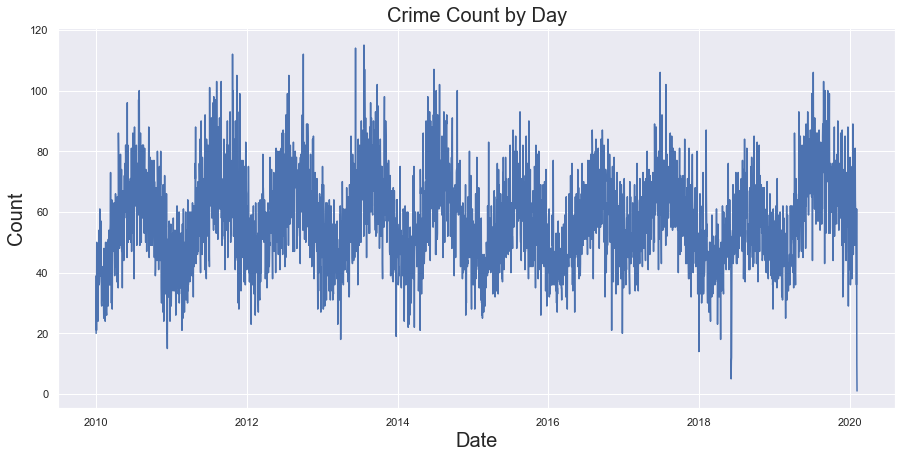

In [56]:
# group crimes by date and plot
import seaborn as sns

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
df_date = df.groupby('Date').count()
df_date.reset_index(inplace=True)
s = sns.lineplot(x='Date', y='Offense', data=df_date)
s.set_xlabel('Date', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Day', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

There is definitely some seasonality involved with crime. We will see this better when we look at crime by temperature, but an educated guess is that crime increases as the weather gets warmer out (this makes a huge difference in Minnesota!)

### crime by day of week

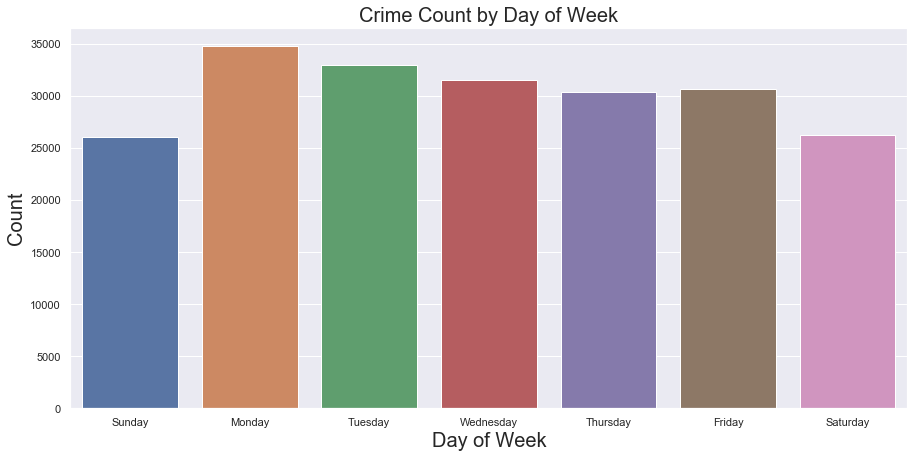

In [57]:
# group crimes by day of week and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x="DoW", order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=df)
s.set_xlabel('Day of Week', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Day of Week', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

Somewhat suprisingly (I guess?) Monday has the highest total crime, followed by Tuesday and then Friday.

### crime by hour of day

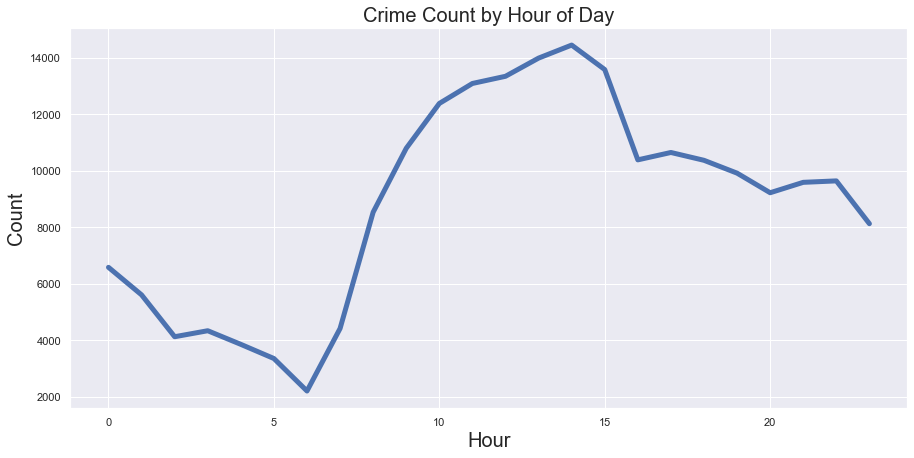

In [58]:
# group crimes by time of day and plot
import seaborn as sns

# set plot specs
sns.set(rc={'figure.figsize':(15, 7), "lines.linewidth": 5})

# plot
df_time = df.groupby('Hour').count()
df_time.reset_index(inplace=True)
s = sns.lineplot(x='Hour', y='Offense', data=df_time)
s.set_xlabel('Hour', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Hour of Day', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

Crime spikes the highest between the hours of 7am through 3pm and then slowly tapers. It then spikes slightly again around 8pm and 10pm. Crime is lowest between the very early morning hours of 12am through 6am.

### crime by type

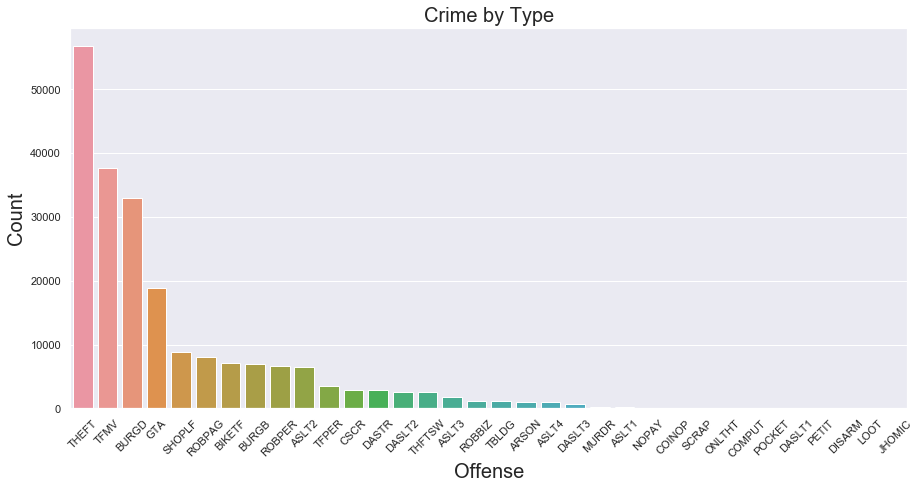

In [59]:
# group crimes by type of crime and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='Offense', order=df['Offense'].value_counts().index, data=df)
s.set_xlabel('Offense', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime by Type', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

Theft (other), theft from motor vehicles, burglary and grand theft auto are far and away the most common crime types in Minneapolis (apparently a lot of kleptomaniacs).

In [ ]:
# look into crime type by day

# pd.set_option('display.max_rows', None)
# df.groupby(['DoW', 'Offense']).count()

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='DoW', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=df, hue='Offense')
s.set_xlabel('DoW', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Type by DoW and Offense', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

### neighborhood breakdown

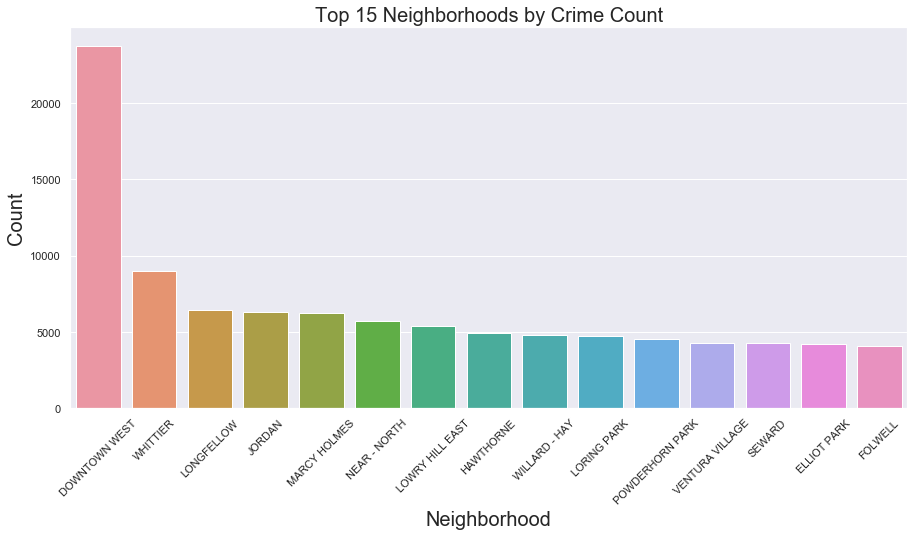

In [60]:
# group crimes by neighborhood and plot to show highest crime neighborhoods

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='Neighborhood', data=df, order=df.Neighborhood.value_counts().iloc[:15].index)
s.set_xlabel('Neighborhood', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Top 15 Neighborhoods by Crime Count', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

Downtown west is far and away the least safe neighborhood followed by Whittier and Marcy Holmes.

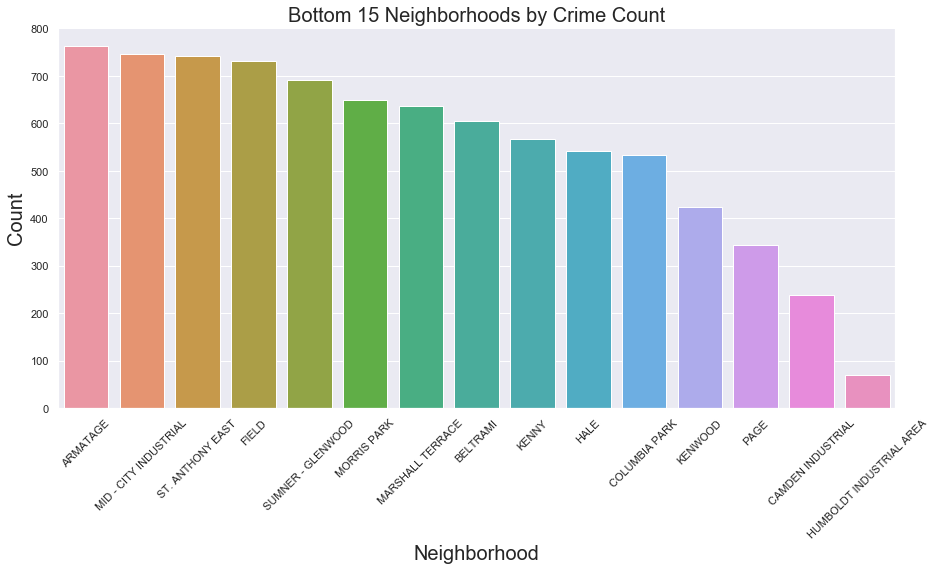

In [61]:
# group crimes by neighborhood and plot to show lowest crime neighborhoods

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='Neighborhood', data=df, order=df.Neighborhood.value_counts().iloc[-15:].index)
s.set_xlabel('Neighborhood', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Bottom 15 Neighborhoods by Crime Count', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

These are our safest neighborhood's by crime counts.

### precinct breakdown

In [62]:
# plot precincts with precinct numbers
precinct = gpd.read_file('Mnpls_Data/Mnpls_Geo_data/Minneapolis_Police_Precincts.shp')
precinct["center"] = precinct["geometry"].centroid
precinct_copy = precinct.copy()
precinct_copy.set_geometry("center", inplace = True)

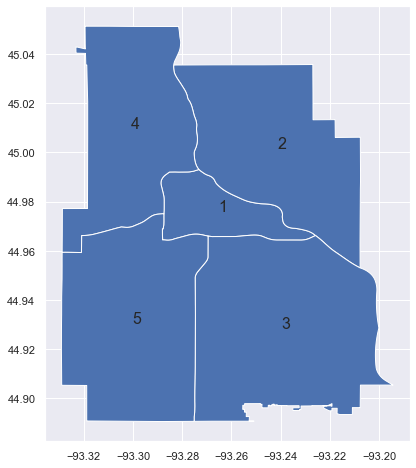

In [63]:
import adjustText as aT

ax = precinct.plot(figsize = (8, 8))
texts = []

for x, y, label in zip(precinct_copy.geometry.x, precinct_copy.geometry.y, precinct_copy["PRECINCT"]):
    texts.append(plt.text(x, y, label, fontsize = 16))

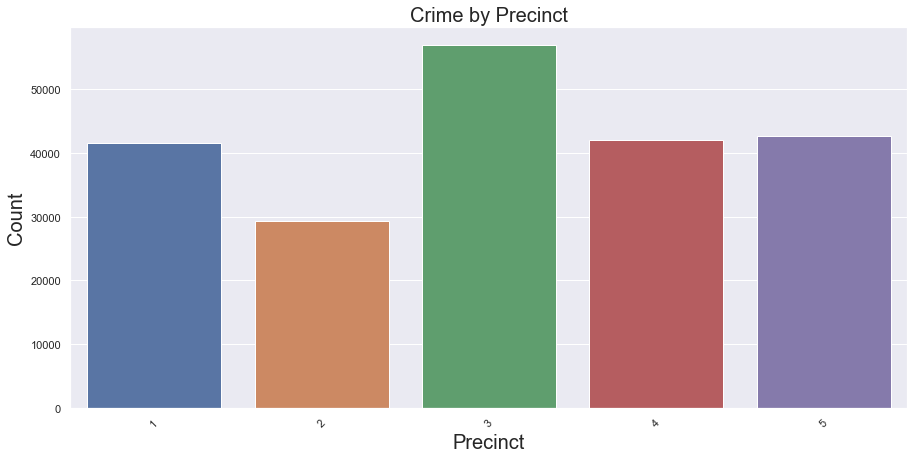

In [64]:
# group crimes by precinct and plot

# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='Precinct', data=df)
s.set_xlabel('Precinct', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime by Precinct', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

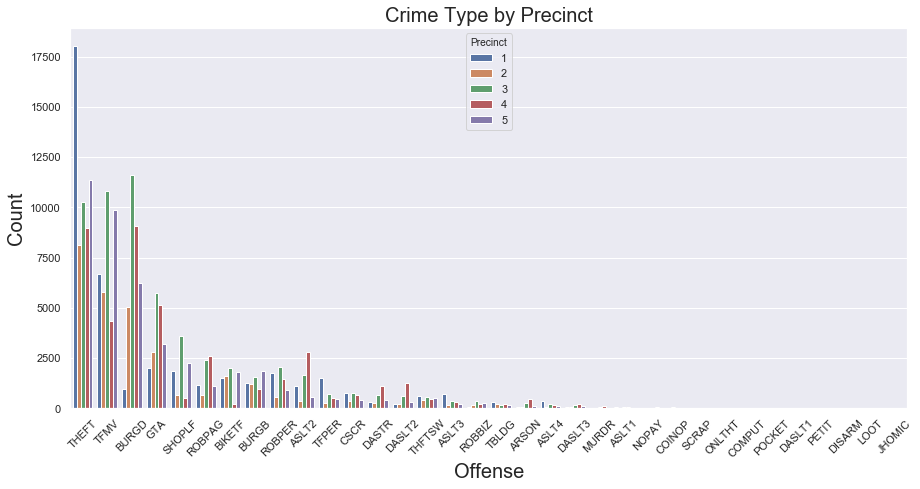

In [65]:
# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
s = sns.countplot(x='Offense', order=df['Offense'].value_counts().index, data=df, hue='Precinct')
s.set_xlabel('Offense', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Type by Precinct', fontsize=20)
s.tick_params(labelsize=11)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.show()

Despite not having the highest overall crime precinct 1 (downtown Minneapolis) far and away has the most thefts. While precinct 3 has the most thefts of a motor vehicle and burglaries. That is not suprising as precinct 3 is far more residential than precinct 1.

### weather effect

In [66]:
# concatenate date and hour together to form join key for crime data
df['Date'] = df['Date'].astype(str)
df['Hour'] = df['Hour'].astype(str)
df['date_join'] = df[['Date', 'Hour']].apply(lambda x: ''.join(x), axis=1)

In [67]:
# join crime and weather data
df_new = df.merge(weather_df, on='date_join', how='left')

In [68]:
df_new.head()

,ReportedDateTime,Lat,Long,Neighborhood,Precinct,Offense,Description,Time_x,Date_x,Hour_x,DoW,date_join,dt,dt_iso,dt_iso_new,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon,Time_y,Date_y,Hour_y
0,2010-01-01 01:56:00+00:00,44.900291,-93.288239,WINDOM,5,CSCR,Crim Sex Cond-rape,01:56:00,2010-01-01,1,Friday,2010-01-011,1262307600,2010-01-01 01:00:00 +0000 UTC,2010-01-01 01:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,6.24,-4.05,3.92,9.50,1025.1,NaN,NaN,68,6.93,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,01:00:00,2010-01-01,1
1,2010-01-01 02:40:00+00:00,44.890636,-93.280041,WINDOM,5,ROBPAG,Robbery Per Agg,02:40:00,2010-01-01,2,Friday,2010-01-012,1262311200,2010-01-01 02:00:00 +0000 UTC,2010-01-01 02:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,4.87,-4.79,3.02,6.98,1025.4,NaN,NaN,72,5.82,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,02:00:00,2010-01-01,2
2,2010-01-01 05:30:00+00:00,44.931448,-93.268841,BRYANT,3,BURGD,Burglary Of Dwelling,05:30:00,2010-01-01,5,Friday,2010-01-015,1262322000,2010-01-01 05:00:00 +0000 UTC,2010-01-01 05:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,1.60,-7.53,-0.94,4.10,1026.1,NaN,NaN,74,4.70,320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,05:00:00,2010-01-01,5
3,2010-01-01 05:45:00+00:00,44.970506,-93.277714,LORING PARK,1,ASLT2,Asslt W/dngrs Weapon,05:45:00,2010-01-01,5,Friday,2010-01-015,1262322000,2010-01-01 05:00:00 +0000 UTC,2010-01-01 05:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,1.60,-7.53,-0.94,4.10,1026.1,NaN,NaN,74,4.70,320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,05:00:00,2010-01-01,5
4,2010-01-01 05:50:00+00:00,45.017746,-93.306988,FOLWELL,4,BURGD,Burglary Of Dwelling,05:50:00,2010-01-01,5,Friday,2010-01-015,1262322000,2010-01-01 05:00:00 +0000 UTC,2010-01-01 05:00:00+00:00,-21600,Minneapolis,44.9773,-93.265469,1.60,-7.53,-0.94,4.10,1026.1,NaN,NaN,74,4.70,320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,05:00:00,2010-01-01,5


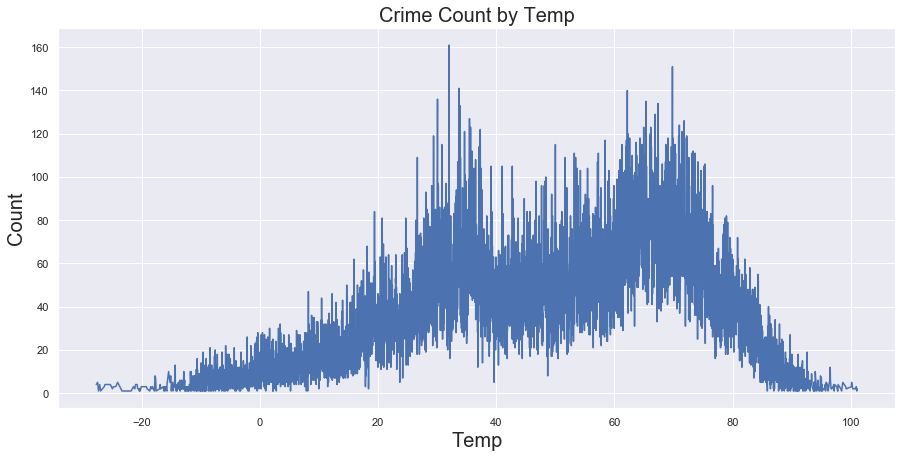

In [69]:
# plot crime count by temp
# set plot specs
sns.set(rc={'figure.figsize':(15, 7)})

# plot
df_temp = df_new.groupby('temp').count()
df_temp.reset_index(inplace=True)
s = sns.lineplot(x='temp', y='Offense', data=df_temp)
s.set_xlabel('Temp', fontsize=20)
s.set_ylabel('Count', fontsize=20)
s.axes.set_title('Crime Count by Temp', fontsize=20)
s.tick_params(labelsize=11)
plt.show()

As expected crime goes down when temperature is reading the extremes either very cold or very hot. I was expecting more of a normal bell shaped curve here but interestingly enough there seem to be two peaks. One around 35 degrees or so and another around 70 degrees.

### geo plotting by neighborhood

In [70]:
# plot neighborhoods with geopandas
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [71]:
hoods = gpd.read_file('Mnpls_Data/Mnpls_Geo_data/Minneapolis_Neighborhoods.shp')

# change column header of BD_NAME to Neighborhood and make neighborhoods uppercase
hoods = hoods.rename(columns={"BDNAME": "Neighborhood"})
hoods['Neighborhood'] = hoods['Neighborhood'].str.upper()

In [72]:
# turn normal df into geo df
# crs = {'init': 'epsg:4326'}
# geometry = [Point(xy) for xy in zip(df_new['Long'], df_new['Lat'])]
# geo_df = gpd.GeoDataFrame(df_new, crs=crs, geometry=geometry)
# geo_df.head()

In [73]:
# first group crime count by neighborhood
crime_grouped = df_new.groupby('Neighborhood').count()

# subset down to just 1 column needed
df_sub = crime_grouped[['Offense']]

# rename column
df_sub = df_sub.rename(columns={"Offense": "Crime_Count"})

# reset index
df_sub = df_sub.reset_index()

In [74]:
# join the geodataframe with the cleaned up csv dataframe
merged_geo = hoods.set_index('Neighborhood').join(df_sub.set_index('Neighborhood'))

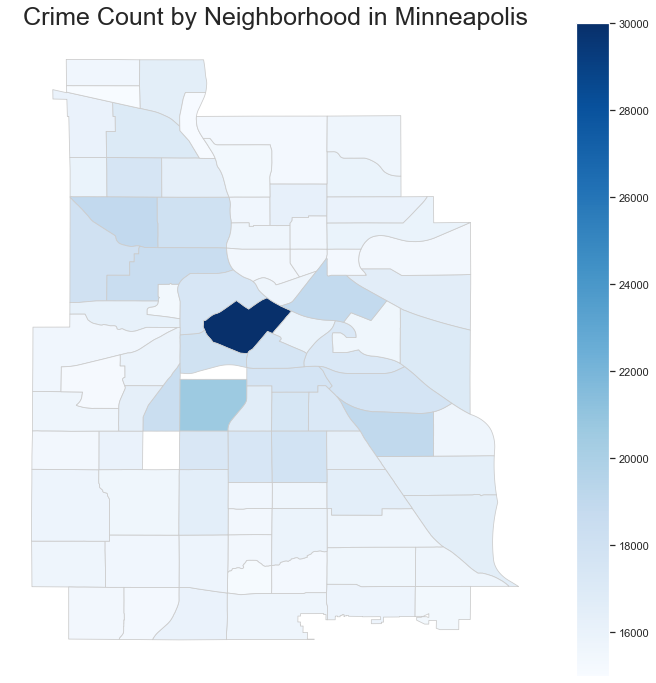

In [95]:
# plot

# set the range for the choropleth
vmin, vmax = 15000, 30000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 12))

# create map
merged_geo.plot('Crime_Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Crime Count by Neighborhood in Minneapolis', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# find centroids
merged_geo["center"] = merged_geo["geometry"].centroid
merged_geo_copy = merged_geo.copy()
merged_geo_copy.set_geometry("center", inplace = True)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('Mnpls_Crime_by_hood.png', dpi=150)

### plotting heatmaps with gmaps

In [76]:
import gmaps
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [98]:
# define df
theft = df_new[df_new['Offense'] == 'THEFT']

# plot
mnpls = (44.9778, -93.2650)
fig = gmaps.figure(center=mnpls, zoom_level=14)
heatmap_layer = gmaps.heatmap_layer(theft[['Lat', 'Long']], max_intensity=100, point_radius=25)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))